# Glossary

1. Population
2. Sampling
3. Emperical distribution
4. Statistic - Point/Interval
5. Sampling distribution
6. Bootstrapping

In [1]:
import random
import time
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import pandas as pd

# Sampling

To *sample* from a set, is to choose elements from that set. In a *random sample*,
the elements are chosen randomly.

The subtlety here, is that the set or *population* can have multiple instances of the same element. This means each *unique* element has an independent probability of being chosen. This spread of probabilities is called the *true distribution* of the population.

In [2]:
def plot_distribution(points, histtype="stepfilled", density=True):
    _ = plt.hist(points, bins="auto", histtype=histtype, density=density)
    return

In [3]:
def fit_to_distr(data, distr, fmt="r-"):
    params  = distr.fit(data)
    
    x = np.linspace(np.min(data), np.max(data), len(data))
    fitted_data = distr.pdf(x, *params)
        
    plot_distribution(data)
    _ = plt.plot(x,fitted_data, fmt)
    return

In [4]:
def print_stats(points):
    print(f"Mean: {np.mean(points)}")
    print(f"Std dev: {np.std(points)}")
    return

In [5]:
N_set = 100000
N_samples = 1000

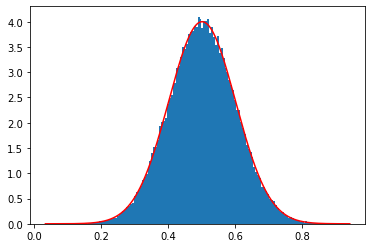

In [6]:
# population
og_set = list(stats.norm(.5, .1).rvs(N_set))
# distribution
fit_to_distr(og_set, stats.norm)

## Random sampling

The population is pictured above. We will now *randomly sample* elements from it. There are two ways to do this:

### without replacement

Choose a random sample of `N_samples`. Successive choices *depend* on previous one

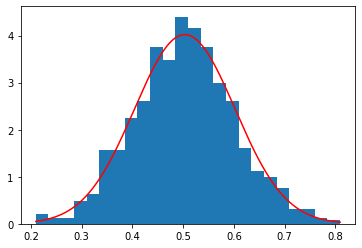

In [7]:
samples = random.sample(og_set, N_samples)
fit_to_distr(samples, stats.norm)

### with replacement

independent random sampling. probability of choosing an element is *not dependent* on earlier choices

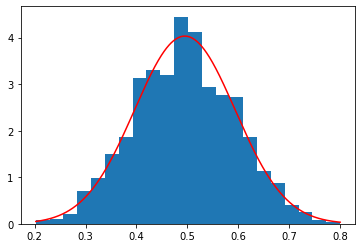

In [8]:
samples = random.choices(og_set, k=N_samples)
fit_to_distr(samples, stats.norm)

### Notice that

*sampling without replacement* **alters the underlying distribution of the set** from which you are sampling. To see this, we visualize the population distribution for both processes:

In [9]:
population = list(stats.norm(.5, .1).rvs(1000))

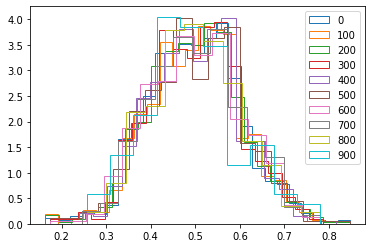

In [10]:
## this simulates sampling without replacement

sampling_set = population
legend = []
for i in range(1000):
    idx = random.choice(range(len(sampling_set)))
    sampling_set = sampling_set[:idx] + sampling_set[idx + 1:]
    if i%(N_samples/10)==0:
        plot_distribution(sampling_set, histtype="step", density=True)
        legend.append(i)
_ = plt.legend(legend)

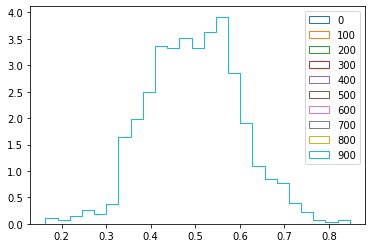

In [11]:
## this simulates sampling with replacement

sampling_set = population
legend = []
for i in range(1000):
    idx = random.choice(range(len(sampling_set)))
#     sampling_set = sampling_set[:idx] + sampling_set[idx + 1:]
    if i%(N_samples/10)==0:
        plot_distribution(sampling_set, histtype="step", density=True)
        legend.append(i)
_ = plt.legend(legend)

# Emperical Distribution

This is the *distribution* of randomly chosen samples.

### Examples

In [12]:
## Standard
distributions = {
    "uniform": stats.uniform(),
    "normal": stats.norm(.5, .1),
    "beta": stats.beta(3,9),
}

In [13]:
## FANCY (but random)
#### random points, independently sampled from a randomly chosen distribution
class Fancy:
    def __init__(self, distrs: dict):
        self.distrs = distrs
    
    def rvs(self, n: int):
        import random
        return [random.choice(list(self.distrs.values())).rvs() for i in range(n)]

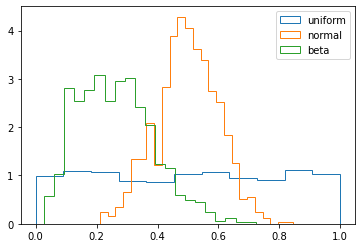

In [14]:
for key, distr in distributions.items():
    points = distr.rvs(size=N_samples)
    plot_distribution(points, histtype="step")
_ = plt.legend(distributions.keys())


## Point estimates

In [15]:
reps = {}
for key, distr in distributions.items():
    points = distr.rvs(size=N_samples)
    reps[key] = {"mean":np.mean(points), "median":np.median(points)}

print(pd.DataFrame(reps))

         uniform    normal      beta
mean    0.476006  0.501993  0.255633
median  0.465346  0.501372  0.239994


In [16]:
points = Fancy(distributions).rvs(N_samples)
print(f"Mean: {np.mean(points)}")
print(f"Median: {np.median(points)}")

Mean: 0.412255014025161
Median: 0.4082681805822138


## Interval estimates

In [17]:
## Median -> Percentiles

assert np.median(points) == np.percentile(points, 0.5*100)

In [18]:
## Confidence intervals

def percentile_around_mean(points, q):
    mean_percentile = np.mean([np.array(points)<np.mean(points)])*100
#     print("Mean percentile: ", mean_percentile)
    lower = mean_percentile - q/2 if mean_percentile > (q/2) else 0
    upper = mean_percentile + q/2 if mean_percentile + (q/2) < 100 else 100
    return (np.percentile(points, lower), np.percentile(points, upper))

def percentile_around_median(points, q):
    p = 100-q
    return (np.percentile(points, p/2), np.percentile(points, 100-p/2))

In [19]:
def plot_lines(points):
    _ = plt.axvline(np.mean(points), color='red', linestyle='dashed', linewidth=1)
    for i in range(10,100, 10):
        _ = plt.axvline(np.percentile(points, i), color='white' if i==50 else 'k', linestyle='dashed', linewidth=1)

50th percentile around mean: (0.4302740163843507, 0.5734231651269203)
50th percentile around median: (0.431363595456024, 0.5739425793840871)


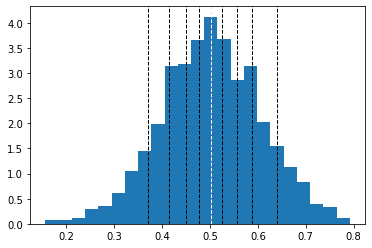

In [20]:
## Normal

points = distributions["normal"].rvs(N_samples)

N_percentile = 50
print(f"{N_percentile}th percentile around mean: {percentile_around_mean(points, N_percentile)}")
print(f"{N_percentile}th percentile around median: {percentile_around_median(points, N_percentile)}")

plot_distribution(points)
plot_lines(points)

50th percentile around mean: (0.23116324135919425, 0.5468320929705442)
50th percentile around median: (0.23387572556378367, 0.548816050898764)


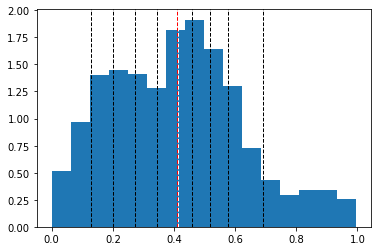

In [21]:
## Fancy
points = Fancy(distributions).rvs(N_samples)

N_percentile = 50
print(f"{N_percentile}th percentile around mean: {percentile_around_mean(points, N_percentile)}")
print(f"{N_percentile}th percentile around median: {percentile_around_median(points, N_percentile)}")

plot_distribution(points)
plot_lines(points)

# Variations in point estimates

## The Law of Large Numbers

Informally, it says that point estimates from an emperical distribution are more accurate (≈ closer to the population distribution) for larger number of random samples (in the emperical distriution).

Below, we visualize this as variations in emperical distributions:

In [22]:
VARIATIONS = 100

### Normal

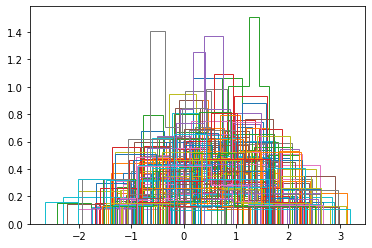

In [23]:
SAMPLE_SIZE = 10
for i in range(VARIATIONS):
    plot_distribution(stats.norm(.5, 1).rvs(SAMPLE_SIZE), histtype='step')

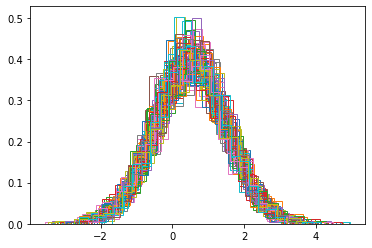

In [24]:
SAMPLE_SIZE = 1000
for i in range(VARIATIONS):
    plot_distribution(stats.norm(.5, 1).rvs(SAMPLE_SIZE), histtype='step')

### Fancy

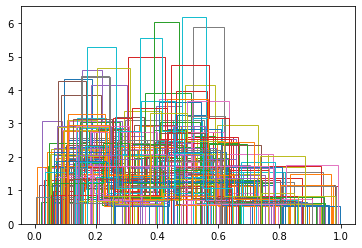

In [25]:
SAMPLE_SIZE = 10
for i in range(VARIATIONS):
    plot_distribution(Fancy(distributions).rvs(SAMPLE_SIZE), histtype='step')

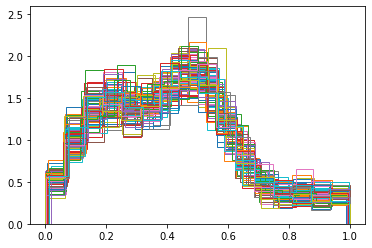

In [26]:
SAMPLE_SIZE = 1000
for i in range(VARIATIONS):
    plot_distribution(Fancy(distributions).rvs(SAMPLE_SIZE), histtype='step')

For lesser random samples, the variations are large. With more and more samples, these variations smoothen out. And in the limiting case of `number of samples -> ∞`, the point estimates of the emperical distribution approach the true point estimates (of the population).

This motivates the next section, where we quantify these variations.

## Sampling Distribution

A *sampling distribution* is a distribution of a point estimate (also called *statistic*) from multiple emperical distributions. That is, for each emperical distribution we calculate the same statistic, and consider the resulting distribtuion.

### Central Limit Theorem

given a sufficiently large sample size, **the sampling distribution of the mean for a random variable will approximate a normal distribution** regardless of that r.v’s distribution in the population.

Mean, median, mode coincide in a NORMAL distribution. Also, has nice closed forms for interval estimates.

In [33]:
def percentile_around_mean_normal(mean, std, q=.95):
    distr = stats.norm(mean, std)
    return distr.ppf((1-q)/2), distr.ppf(q+(1-q)/2)

mean = .5
std = .1
q = .95
assert percentile_around_mean_normal(mean, std, q) == stats.norm.interval(alpha=q, loc=mean, scale=std)

In [38]:
SAMPLINGS = 1000

Mean: 0.41617641633574026
Std dev: 0.002527048276919338


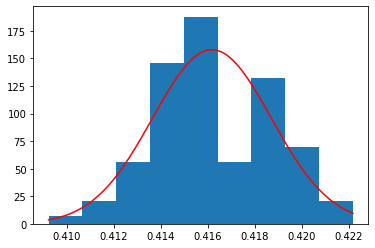

In [49]:
## Fancy

distr = Fancy(distributions)
means = [np.mean(distr.rvs(N_samples)) for i in range(SAMPLINGS)]
print_stats(means)
fit_to_distr(means, stats.norm)

In [51]:
print("95% confidence interval for the mean")
print(percentile_around_mean_normal(np.mean(means), np.std(means), q=.95))
print(f"{np.mean(means)} ± {1.96*np.std(means)}")

95% confidence interval for the mean
(0.41122349272578435, 0.4211293399456962)
0.41617641633574026 ± 0.004953014622761903


Mean: 0.4999486557652939
Std dev: 0.0010335516624866974


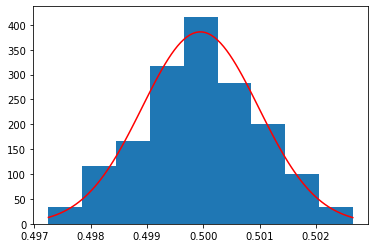

In [47]:
## Normal

distr = stats.norm(.5,.1)
means = [np.mean(distr.rvs(N_samples)) for i in range(SAMPLINGS)]
print_stats(means)
fit_to_distr(means, stats.norm)

In [48]:
print("95% confidence interval for the mean")
print(percentile_around_mean_normal(np.mean(means), np.std(means), q=.95))
print(f"{np.mean(means)} ± {1.96*np.std(means)}")

95% confidence interval for the mean
(0.4979229317306585, 0.5019743797999293)
0.4999486557652939 ± 0.0020257612584739268


## Bootstrapping

The *bootstrapping principle* is based on **resampling** a single emperical distribution, multiple times.

Let `mu` be the true statistic, and `mu_` be an emperical estimate. On resampling (with replacement) from the emperical distribution, let `mu*` be the resulting estimate. The principle says that we can estimate the variation of `mu` with the variation of `mu*`. That is, the distribution of (`mu_` - `mu`) ≈ distribution of (`mu*` - `mu_`).

Since we can *resample* from the emperical distribution many times, it is easier to estimate this alternate distribution. 

### Emperical Bootstrap

In [72]:
N_samples = 10000
N_bootstraps = 1000
percentile = 80

Mean: 8.950697069473445e-05
Std dev: 0.002223212800532852
80th percentile: (0.41510913523542176, 0.4205428463965535)


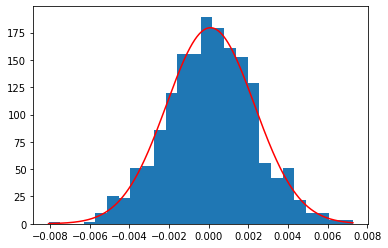

In [73]:
# Fancy

points = Fancy(distributions).rvs(N_samples)
mu_ = np.mean(points) 
deltas = [np.mean(random.choices(points, k=len(points))) - mu_ for i in range(N_bootstraps)]

print_stats(deltas)
fit_to_distr(deltas, stats.norm)

q = percentile
lower, upper = np.percentile(deltas, 50 - q/2), np.percentile(deltas, 50 + q/2)
print(f"{q}th percentile: ({mu_-upper}, {mu_-lower})")

Mean: 1.930837139565783e-05
Std dev: 0.0009572249313032984
80th percentile: (0.49850994129952025, 0.5009351862960327)


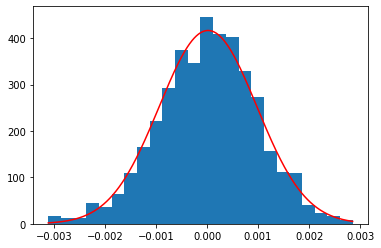

In [74]:
# Normal

points = stats.norm(.5,.1).rvs(N_samples)
mu_ = np.mean(points) 
deltas = [np.mean(random.choices(points, k=len(points))) - mu_ for i in range(N_bootstraps)]

print_stats(deltas)
fit_to_distr(deltas, stats.norm)

q = percentile
lower, upper = np.percentile(deltas, 50 - q/2), np.percentile(deltas, 50 + q/2)
print(f"{q}th percentile: ({mu_-upper}, {mu_-lower})")

### Parametric bootstrap

FIT:  0.5956 0.4907755495132169
TRUE:  0.6


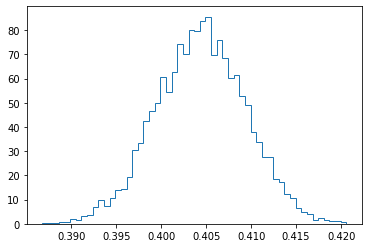

In [35]:
## Beta Binomial

N_samples = 10000
P = 0.6

## simulate a population. mostly seen in binary metrics like Reservation Rate
bernoulli = stats.bernoulli(P)
points = bernoulli.rvs(N_samples)

## beta-binomial
## BAYES THEOREM := Posterior = Prior * Likelihood
predicted_distr = stats.beta(np.sum([np.array(points)==0]), np.sum([np.array(points)==1]))
predicted_points = predicted_distr.rvs(N_samples)
plot_distribution(predicted_points, histtype='step')
print("FIT: ", np.mean(points), np.std(points))
print("TRUE: ", P)

# Epilogue

As a prologue to the next session, we'll try bootstrapping the previous example.

Mean: 0.5940156
Std dev: 0.005018710655138428


/Users/knethil/.pyenv/versions/3.8.2/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


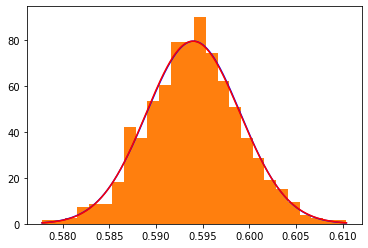

In [36]:
## Beta Binomial

N_samples = 10000
P = 0.6

## simulate a population. mostly seen in binary metrics like Reservation Rate
bernoulli = stats.bernoulli(P)
points = bernoulli.rvs(N_samples)


## bootstrapping
N_bootstraps = 1000
means = [np.mean(random.choices(points, k=len(points))) for i in range(N_bootstraps)]
print_stats(means)
fit_to_distr(means, stats.norm, "b-")
fit_to_distr(means, stats.beta, "r-")

### Notice

how both normal and beta fits coincide. Knowing what beta distributions look like (from earlier), this is surprising! 

Mean: 0.156582
Std dev: 0.003596575593533382


/Users/knethil/.pyenv/versions/3.8.2/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


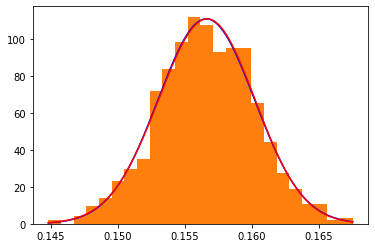

In [75]:
## Beta Binomial

N_samples = 10000
P = 0.15

## simulate a population. mostly seen in binary metrics like Reservation Rate
bernoulli = stats.bernoulli(P)
points = bernoulli.rvs(N_samples)


## bootstrapping
N_bootstraps = 1000
means = [np.mean(random.choices(points, k=len(points))) for i in range(N_bootstraps)]
print_stats(means)
fit_to_distr(means, stats.norm, "b-")
fit_to_distr(means, stats.beta, "r-")

Why dont they coincide now ?